<a href="https://colab.research.google.com/github/goodnessezichioum/DS-final-project/blob/main/economic-assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
from functools import reduce
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import classification_report, confusion_matrix
from datetime import datetime
from scipy import stats
from scipy.stats import shapiro, normaltest
from statsmodels.tsa.stattools import adfuller
import joblib
import pickle
import json

In [55]:
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Setting random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [56]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
!ls "/content/drive/MyDrive"


 API_NGA_DS2_en_csv_v2_130484   IMDB_overview_genres.csv
'Colab Notebooks'	        Multimodal_IMDB_dataset
 housing.csv		        spark-3.3.0-bin-hadoop3.tgz
 Images


In [58]:
csv_path = "/content/drive/MyDrive/API_NGA_DS2_en_csv_v2_130484/API_NGA_DS2_en_csv_v2_130484.csv"
df_raw = pd.read_csv(csv_path, header=2)

df_raw.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,Unnamed: 69
0,Nigeria,NGA,"Industry (including construction), value added...",NV.IND.EMPL.KD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.323377e+04,1.364962e+04,1.238158e+04,1.129614e+04,1.065833e+04,1.093960e+04,1.082549e+04,1.058846e+04,9.866392e+03,1.025967e+04,1.047256e+04,1.028540e+04,1.112731e+04,1.094869e+04,1.119730e+04,1.103451e+04,1.083389e+04,1.058920e+04,1.080453e+04,1.126627e+04,1.203161e+04,1.117395e+04,1.034883e+04,1.040863e+04,9.682647e+03,8.442150e+03,8.180626e+03,7.897489e+03,7.643102e+03,6.466857e+03,5.858894e+03,4.845714e+03,4.547890e+03,NaN,NaN
1,Nigeria,NGA,"Agriculture, forestry, and fishing, value adde...",NV.AGR.TOTL.KN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.364373e+12,2.425961e+12,2.409082e+12,2.303505e+12,2.731062e+12,2.986835e+12,2.891672e+12,3.174568e+12,3.325947e+12,3.464716e+12,3.590837e+12,3.674793e+12,3.743666e+12,3.839675e+12,3.977382e+12,4.133548e+12,4.305680e+12,4.475241e+12,4.703644e+12,4.840971e+12,5.024542e+12,7.817084e+12,8.364832e+12,8.888573e+12,9.516992e+12,1.022247e+13,1.095847e+13,1.164537e+13,1.233033e+13,1.304889e+13,1.342938e+13,1.432971e+13,1.475052e+13,1.538039e+13,1.595222e+13,1.660734e+13,1.717950e+13,1.754415e+13,1.795858e+13,1.834818e+13,1.873841e+13,1.909107e+13,1.930649e+13,1.953588e+13,NaN
2,Nigeria,NGA,"Agriculture, forestry, and fishing, value adde...",NV.AGR.TOTL.CD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.013244e+10,1.927770e+10,1.455524e+10,1.345378e+10,1.344212e+10,9.876248e+09,1.082604e+10,1.160367e+10,9.361914e+09,1.164810e+10,1.243235e+10,1.057883e+10,1.332442e+10,2.023968e+10,3.591553e+10,4.865976e+10,5.506645e+10,6.095640e+10,1.539457e+10,1.477311e+10,1.800354e+10,3.513681e+10,3.543011e+10,3.696935e+10,4.583119e+10,5.898182e+10,6.862630e+10,8.581876e+10,7.891148e+10,8.768760e+10,9.215547e+10,1.014239e+11,1.079692e+11,1.147808e+11,1.017207e+11,8.490797e+10,7.833010e+10,8.942464e+10,1.039492e+11,1.043471e+11,1.029658e+11,1.131058e+11,8.268385e+10,3.821519e+10,NaN
3,Nigeria,NGA,External balance on goods and services (consta...,NE.RSB.GNFS.KN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Nigeria,NGA,Imports of goods and services (constant LCU),NE.IMP.GNFS.KN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
df_raw = df_raw[df_raw["Country Code"] == "NGA"].reset_index(drop=True)

In [60]:
year_cols = [col for col in df_raw.columns if re.match(r"^\d{4}$", str(col))]

# Keeping only descriptive columns + year columns to simplify dataset
df = df_raw[["Indicator Name", "Indicator Code"] + year_cols].copy()

print(df.shape)
df.head()



(1516, 67)


,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,"Industry (including construction), value added...",NV.IND.EMPL.KD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.323377e+04,1.364962e+04,1.238158e+04,1.129614e+04,1.065833e+04,1.093960e+04,1.082549e+04,1.058846e+04,9.866392e+03,1.025967e+04,1.047256e+04,1.028540e+04,1.112731e+04,1.094869e+04,1.119730e+04,1.103451e+04,1.083389e+04,1.058920e+04,1.080453e+04,1.126627e+04,1.203161e+04,1.117395e+04,1.034883e+04,1.040863e+04,9.682647e+03,8.442150e+03,8.180626e+03,7.897489e+03,7.643102e+03,6.466857e+03,5.858894e+03,4.845714e+03,4.547890e+03,NaN
1,"Agriculture, forestry, and fishing, value adde...",NV.AGR.TOTL.KN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.364373e+12,2.425961e+12,2.409082e+12,2.303505e+12,2.731062e+12,2.986835e+12,2.891672e+12,3.174568e+12,3.325947e+12,3.464716e+12,3.590837e+12,3.674793e+12,3.743666e+12,3.839675e+12,3.977382e+12,4.133548e+12,4.305680e+12,4.475241e+12,4.703644e+12,4.840971e+12,5.024542e+12,7.817084e+12,8.364832e+12,8.888573e+12,9.516992e+12,1.022247e+13,1.095847e+13,1.164537e+13,1.233033e+13,1.304889e+13,1.342938e+13,1.432971e+13,1.475052e+13,1.538039e+13,1.595222e+13,1.660734e+13,1.717950e+13,1.754415e+13,1.795858e+13,1.834818e+13,1.873841e+13,1.909107e+13,1.930649e+13,1.953588e+13
2,"Agriculture, forestry, and fishing, value adde...",NV.AGR.TOTL.CD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.013244e+10,1.927770e+10,1.455524e+10,1.345378e+10,1.344212e+10,9.876248e+09,1.082604e+10,1.160367e+10,9.361914e+09,1.164810e+10,1.243235e+10,1.057883e+10,1.332442e+10,2.023968e+10,3.591553e+10,4.865976e+10,5.506645e+10,6.095640e+10,1.539457e+10,1.477311e+10,1.800354e+10,3.513681e+10,3.543011e+10,3.696935e+10,4.583119e+10,5.898182e+10,6.862630e+10,8.581876e+10,7.891148e+10,8.768760e+10,9.215547e+10,1.014239e+11,1.079692e+11,1.147808e+11,1.017207e+11,8.490797e+10,7.833010e+10,8.942464e+10,1.039492e+11,1.043471e+11,1.029658e+11,1.131058e+11,8.268385e+10,3.821519e+10
3,External balance on goods and services (consta...,NE.RSB.GNFS.KN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Imports of goods and services (constant LCU),NE.IMP.GNFS.KN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
#function for longest run
def longest_run_nonmissing(row):
    longest = current = 0
    for col in year_cols:
        if pd.notna(row[col]):
            current += 1
            longest = max(longest, current)
        else:
            current = 0
    return longest

df["coverage_%"] = df[year_cols].notna().mean(axis=1) * 100
df["first_year"] = df[year_cols].apply(lambda r: r.first_valid_index(), axis=1)
df["last_year"]  = df[year_cols].apply(lambda r: r.last_valid_index(), axis=1)
df["longest_run"] = df.apply(longest_run_nonmissing, axis=1)


capital_keywords = [
    "capital formation", "gross fixed", "investment", "savings",
    "government expenditure", "capital stock"
]

external_keywords = [
    "export", "import", "trade", "balance", "fdi", "foreign direct", "current account"
]

# filtering each category
capital_df = (
    df[df["Indicator Name"].str.contains("|".join(capital_keywords), case=False, na=False)]
    .sort_values(by="coverage_%", ascending=False)
)

external_df = (
    df[df["Indicator Name"].str.contains("|".join(external_keywords), case=False, na=False)]
    .sort_values(by="coverage_%", ascending=False)
)

print(" Top 5 Capital Indicators ")
print(capital_df[["Indicator Name", "Indicator Code", "coverage_%", "longest_run"]].head(5))

print("\n Top 5 External Indicators ")
print(external_df[["Indicator Name", "Indicator Code", "coverage_%", "longest_run"]].head(5))


 Top 5 Capital Indicators 
                                         Indicator Name        Indicator Code  \
1204  Foreign direct investment, net inflows (% of GDP)  BX.KLT.DINV.WD.GD.ZS   
1145  Foreign direct investment, net inflows (BoP, c...     BX.KLT.DINV.CD.WD   
1453  Adjusted savings: education expenditure (% of ...     NY.ADJ.AEDU.GN.ZS   
65    Adjusted savings: consumption of fixed capital...     NY.ADJ.DKAP.GN.ZS   
1413  Adjusted savings: natural resources depletion ...     NY.ADJ.DRES.GN.ZS   

      coverage_%  longest_run  
1204   84.615385           55  
1145   84.615385           55  
1453   80.000000           52  
65     80.000000           52  
1413   80.000000           52  

 Top 5 External Indicators 
                                        Indicator Name     Indicator Code  \
577                  Merchandise imports (current US$)  TM.VAL.MRCH.CD.WT   
638                  Merchandise exports (current US$)  TX.VAL.MRCH.CD.WT   
453                       Merchand

In [62]:
def extract_indicator(df, code, name, year_cols):
    year_cols = [str(y) for y in range(1960, 2025)]
    row = df[df["Indicator Code"] == code]
    ts = row[year_cols].T
    ts.columns = [name]
    ts.index.name = "Year"
    ts.reset_index(inplace=True)
    ts["Year"] = ts["Year"].astype(int)
    ts[name] = pd.to_numeric(ts[name], errors="coerce")
    return ts

In [63]:
#Extracting indicators

indicators = {
    # TARGET VARIABLE -  GDP Growth Rate
    "NY.GDP.MKTP.KD.ZG": "GDP_Growth",  # GDP growth (annual %)

    # Feature variables (selected based on data availability and economic relevance)
    "NY.GDP.DEFL.KD.ZG": "Inflation",          # Inflation rate (%)
    "SP.POP.GROW": "Population_Growth",         # Population growth rate (%)
    "BX.KLT.DINV.WD.GD.ZS": "FDI_inflows",     # Foreign Direct Investment (% of GDP)
     "TX.VAL.MRCH.CD.WT": "Exports",           # Goods exports
    "SL.UEM.TOTL.ZS": "Unemployment",          # Unemployment rate (%)
}


In [64]:
dataframes = {}
for code, name in indicators.items():
    ts = extract_indicator( df, code, name, year_cols)
    if ts is not None:
        dataframes[name] = ts

In [65]:
df_merged = dataframes["GDP_Growth"].copy()
for name, ts in dataframes.items():
    if name != "GDP_Growth":
        df_merged = df_merged.merge(ts, on="Year", how="outer")

df_merged = df_merged.sort_values("Year").reset_index(drop=True)
print(f"Merged dataset: {df_merged.shape[0]} years, {df_merged.shape[1]} columns")

df_merged.isna().sum()


Merged dataset: 65 years, 7 columns


,0
Year,0
GDP_Growth,1
Inflation,1
Population_Growth,1
FDI_inflows,10
Exports,0
Unemployment,31


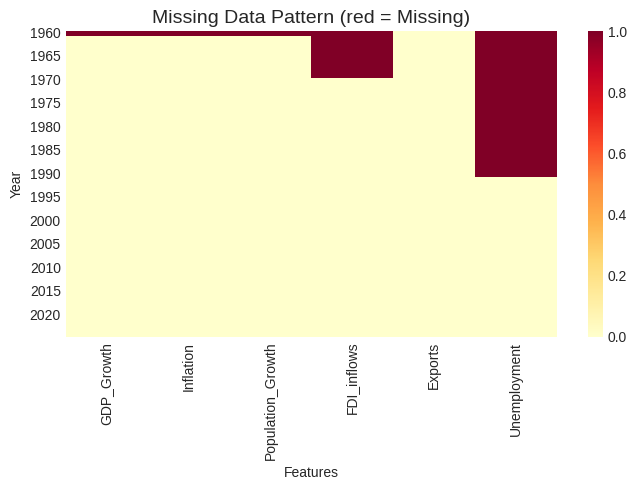

01_missing_data_pattern.png


In [66]:
fig, ax = plt.subplots(figsize=(7, 5))
missing_matrix = df_merged.set_index('Year').isna().astype(int)
sns.heatmap(missing_matrix, cbar=True, yticklabels=5, cmap='YlOrRd', ax=ax)
ax.set_title('Missing Data Pattern (red = Missing)', fontsize=14)
ax.set_xlabel('Features')
ax.set_ylabel('Year')
plt.tight_layout()
plt.show()
print("01_missing_data_pattern.png")


In [67]:
#Dropping na values over 30 years

df_clean = df_merged.dropna()
df_clean.isna().sum()

,0
Year,0
GDP_Growth,0
Inflation,0
Population_Growth,0
FDI_inflows,0
Exports,0
Unemployment,0


In [68]:
df_clean.head()

,Year,GDP_Growth,Inflation,Population_Growth,FDI_inflows,Exports,Unemployment
31,1991,0.358353,18.863907,2.641103,1.196726,1.226400e+10,3.851
32,1992,4.631193,46.752355,2.625288,1.722383,1.188600e+10,3.810
33,1993,-2.035119,41.639059,2.650148,2.371903,9.908000e+09,4.038
34,1994,-1.814924,43.296464,2.641357,2.436852,9.415000e+09,4.078
35,1995,-0.072665,75.401653,2.636629,0.238322,1.234200e+10,4.163


In [69]:
print("\n6.1 STATIONARITY TEST (Augmented Dickey-Fuller)")
print("-" * 50)

def adf_test(series, name):
    result = adfuller(series.dropna())
    adf_stat = result[0]
    p_value = result[1]
    is_stationary = p_value < 0.05

    print(f"\n{name}:")
    print(f"  ADF Statistic: {adf_stat:.4f}")
    print(f"  p-value: {p_value:.4f}")
    print(f"  Stationary: {'YES ✓' if is_stationary else 'NO ✗'}")
    return is_stationary, p_value

stat_growth, p_growth = adf_test(df_clean['GDP_Growth'], "GDP Growth Rate")

if stat_growth:
    print("\n✓ GDP Growth is stationary ")
else:
    print("\n⚠ GDP Growth may not be stationary")
    # suitable for time series modeling


6.1 STATIONARITY TEST (Augmented Dickey-Fuller)
--------------------------------------------------

GDP Growth Rate:
  ADF Statistic: -3.0099
  p-value: 0.0340
  Stationary: YES ✓

✓ GDP Growth is stationary 



6.2 Creating GDP Growth time series plot...


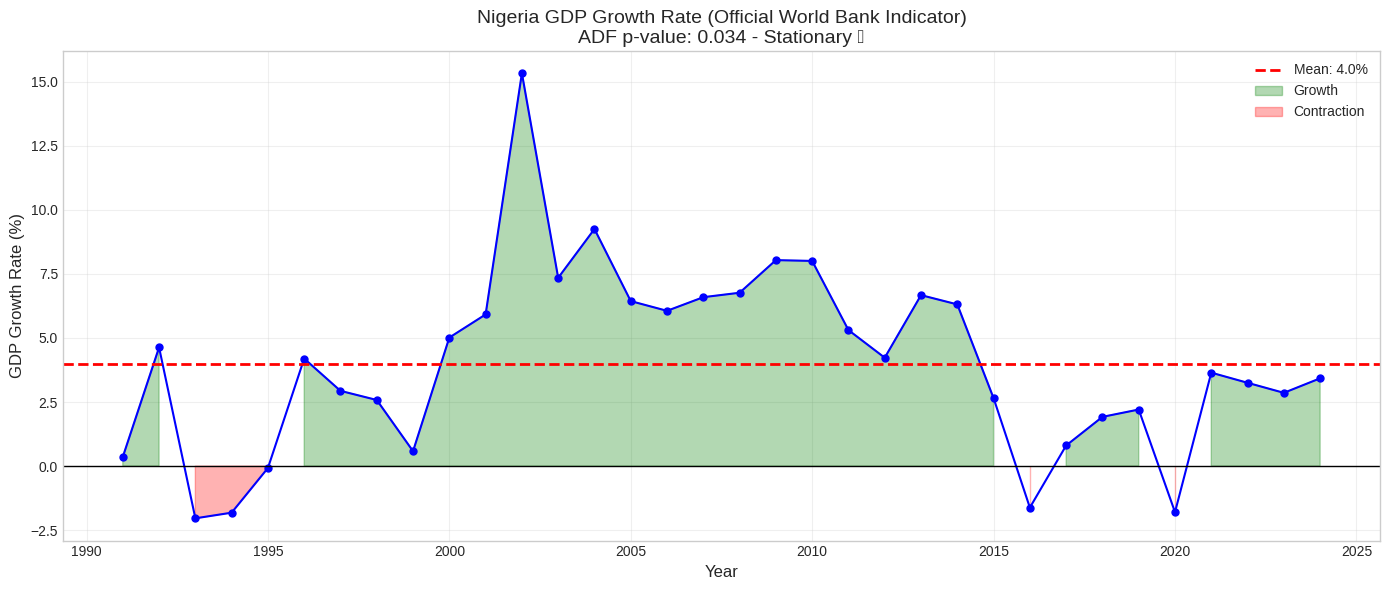

In [70]:
print("\n6.2 Creating GDP Growth time series plot...")

fig, ax = plt.subplots(figsize=(14, 6))

# Plotting GDP Growth
ax.plot(df_clean['Year'], df_clean['GDP_Growth'], 'b-o', markersize=5, linewidth=1.5)
ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.axhline(y=df_clean['GDP_Growth'].mean(), color='red', linestyle='--',
           linewidth=2, label=f'Mean: {df_clean["GDP_Growth"].mean():.1f}%')

# Color regions
ax.fill_between(df_clean['Year'], 0, df_clean['GDP_Growth'],
                where=(df_clean['GDP_Growth'] >= 0), alpha=0.3, color='green', label='Growth')
ax.fill_between(df_clean['Year'], 0, df_clean['GDP_Growth'],
                where=(df_clean['GDP_Growth'] < 0), alpha=0.3, color='red', label='Contraction')

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('GDP Growth Rate (%)', fontsize=12)
ax.set_title(f'Nigeria GDP Growth Rate (Official World Bank Indicator)\nADF p-value: {p_growth:.3f} - {"Stationary ✓" if stat_growth else "Non-stationary"}', fontsize=14)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



6.3 Creating GDP Growth distribution plot


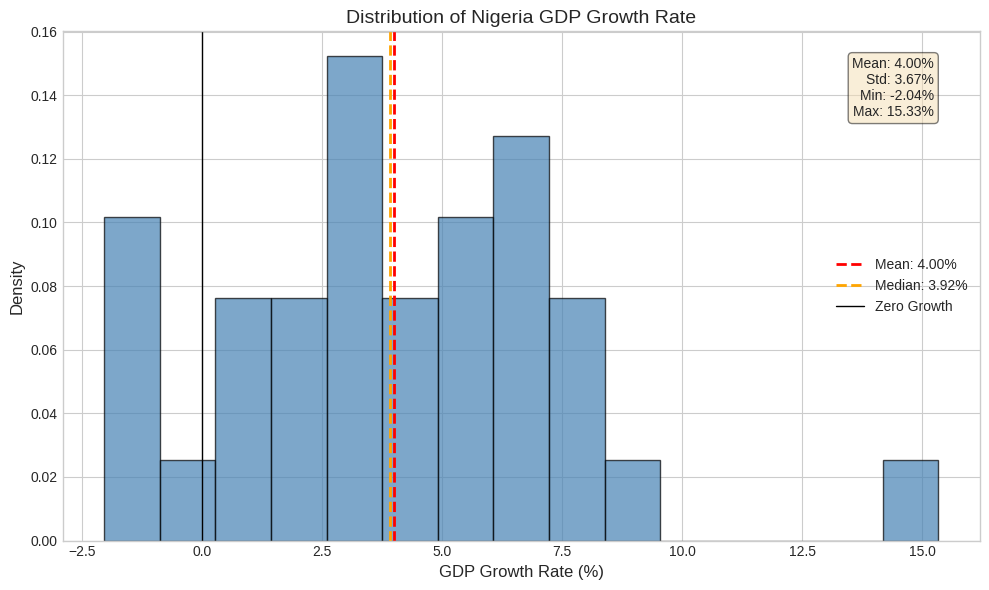


GDP Growth Summary Statistics:
  Mean:   4.00%
  Median: 3.92%
  Std:    3.67%
  Min:    -2.04%
  Max:    15.33%


In [71]:
print("\n6.3 Creating GDP Growth distribution plot")

fig, ax = plt.subplots(figsize=(10, 6))

mean_growth = df_clean['GDP_Growth'].mean()
median_growth = df_clean['GDP_Growth'].median()
std_growth = df_clean['GDP_Growth'].std()

ax.hist(df_clean['GDP_Growth'], bins=15, density=True, alpha=0.7,
        color='steelblue', edgecolor='black')

ax.axvline(mean_growth, color='red', linestyle='--', linewidth=2,
           label=f'Mean: {mean_growth:.2f}%')
ax.axvline(median_growth, color='orange', linestyle='--', linewidth=2,
           label=f'Median: {median_growth:.2f}%')
ax.axvline(0, color='black', linestyle='-', linewidth=1, label='Zero Growth')

ax.set_xlabel('GDP Growth Rate (%)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Distribution of Nigeria GDP Growth Rate', fontsize=14)
ax.legend()

# Adding stats text box
stats_text = f'Mean: {mean_growth:.2f}%\nStd: {std_growth:.2f}%\nMin: {df_clean["GDP_Growth"].min():.2f}%\nMax: {df_clean["GDP_Growth"].max():.2f}%'
ax.text(0.95, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()
plt.close()

print(f"\nGDP Growth Summary Statistics:")
print(f"  Mean:   {mean_growth:.2f}%")
print(f"  Median: {median_growth:.2f}%")
print(f"  Std:    {std_growth:.2f}%")
print(f"  Min:    {df_clean['GDP_Growth'].min():.2f}%")
print(f"  Max:    {df_clean['GDP_Growth'].max():.2f}%")



6.4 Creating correlation matrix


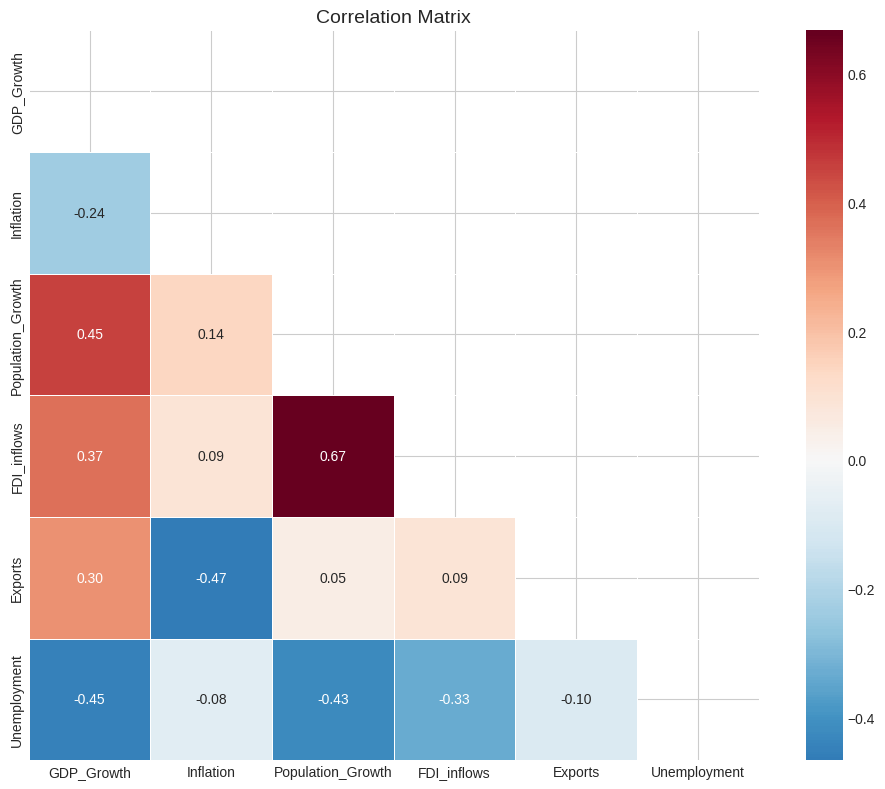

  Saved: 03_correlation_matrix.png

Correlations with GDP Growth:
  Population_Growth   : +0.451 (Moderate)
  Unemployment        : -0.450 (Moderate)
  FDI_inflows         : +0.370 (Moderate)
  Exports             : +0.300 (Weak)
  Inflation           : -0.239 (Weak)


In [72]:
print("\n6.4 Creating correlation matrix")

# Getting numeric columns for correlation
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != 'Year']

corr_matrix = df_clean[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0,
            mask=mask, square=True, linewidths=0.5, fmt='.2f',
            annot_kws={'size': 10}, ax=ax)
ax.set_title('Correlation Matrix', fontsize=14)
plt.tight_layout()
plt.show()
plt.savefig('03_correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.close()
print("  Saved: 03_correlation_matrix.png")

# Printing correlations with GDP Growth
print("\nCorrelations with GDP Growth:")
gdp_corr = corr_matrix['GDP_Growth'].drop('GDP_Growth').sort_values(key=abs, ascending=False)
for feat, corr in gdp_corr.items():
    strength = "Strong" if abs(corr) > 0.5 else "Moderate" if abs(corr) > 0.3 else "Weak"
    print(f"  {feat:20s}: {corr:+.3f} ({strength})")



6.5 Creating time series plots for all features


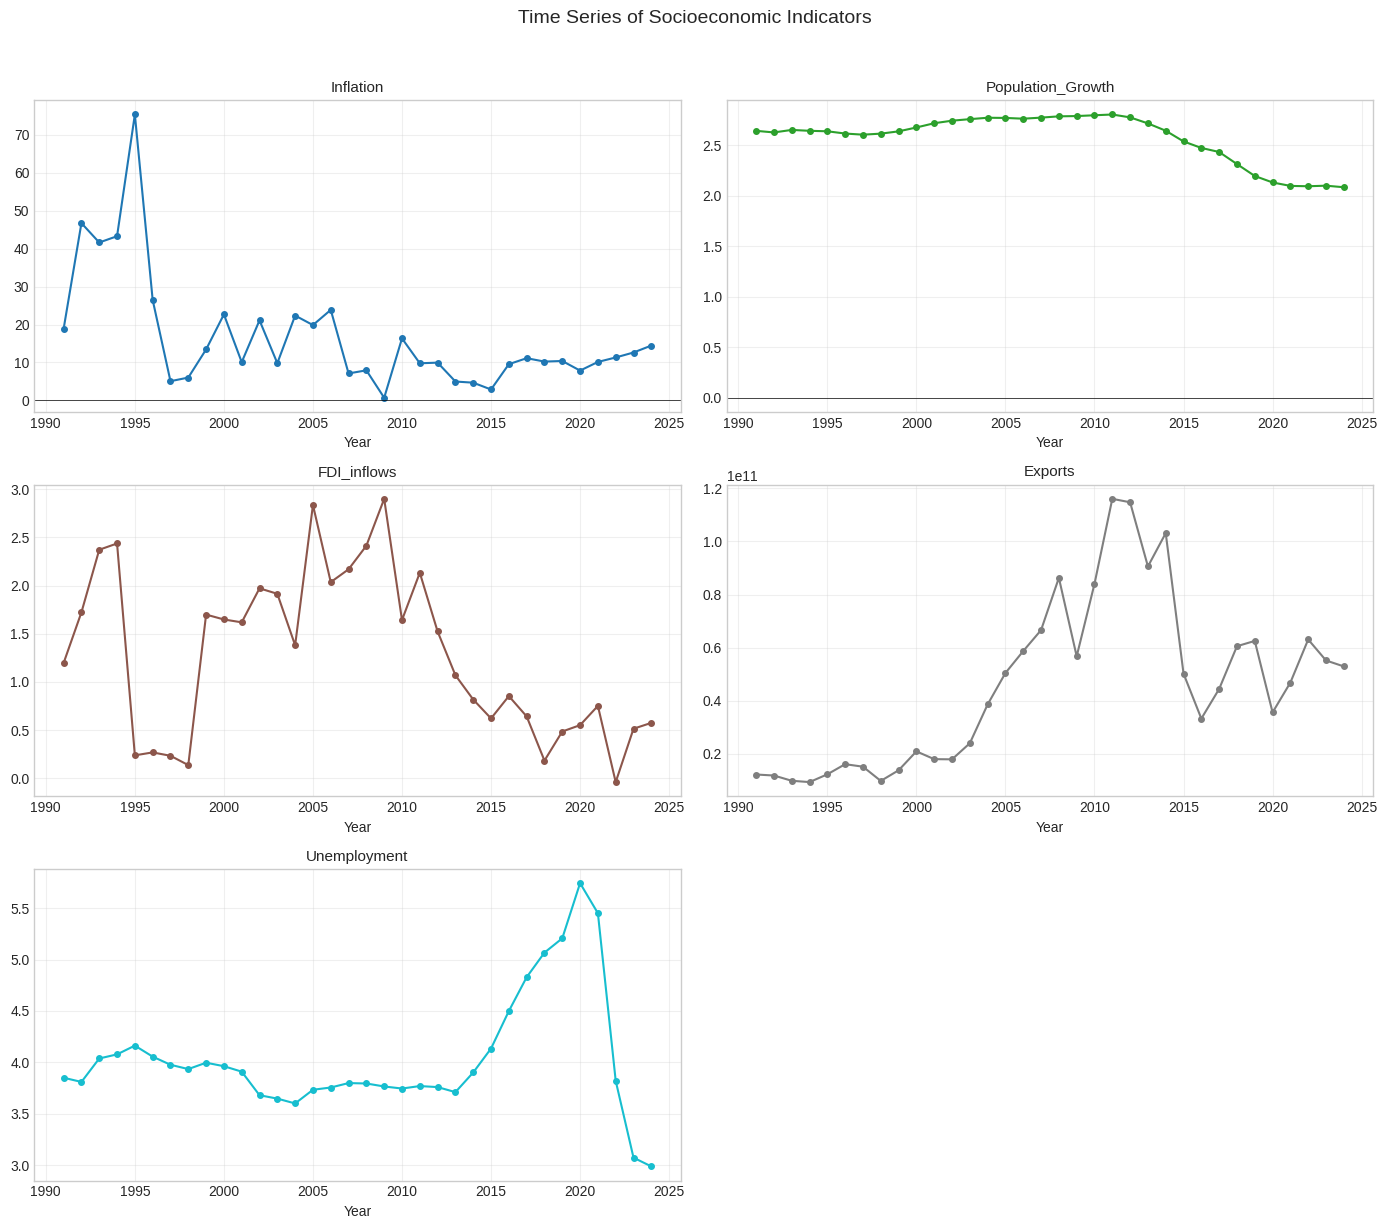

In [73]:
print("\n6.5 Creating time series plots for all features")

feature_cols_plot = [c for c in numeric_cols if c != 'GDP_Growth']
n_features = len(feature_cols_plot)
n_rows = (n_features + 1) // 2

fig, axes = plt.subplots(n_rows, 2, figsize=(14, 4*n_rows))
axes = axes.flatten()

colors = plt.cm.tab10(np.linspace(0, 1, n_features))

for i, col in enumerate(feature_cols_plot):
    ax = axes[i]
    ax.plot(df_clean['Year'], df_clean[col], marker='o', markersize=4,
            linewidth=1.5, color=colors[i])
    ax.set_title(f'{col}', fontsize=11)
    ax.set_xlabel('Year')
    ax.grid(True, alpha=0.3)
    if 'Growth' in col or col == 'Inflation' or col == 'Current_Account':
        ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Hiding empty subplots
for i in range(n_features, len(axes)):
    axes[i].set_visible(False)

plt.suptitle('Time Series of Socioeconomic Indicators', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [74]:
#Feature engineering

df_featured = df_clean.copy()

df_featured['Exports_Growth'] = df_featured['Exports'].pct_change() * 100
# GDP Growth lags
df_featured['GDP_Growth_lag_1'] = df_featured['GDP_Growth'].shift(1)

df_featured['GDP_Growth_lag_2'] = df_featured['GDP_Growth'].shift(2)

# Inflation lag
df_featured['Inflation_lag_1'] = df_featured['Inflation'].shift(1)

# Rolling mean
df_featured['GDP_Growth_rolling_mean_3'] = df_featured['GDP_Growth'].rolling(window=3).mean()

# Dropping rows with NaN created by lag/rolling operations
df_featured = df_featured.dropna().reset_index(drop=True)

# Dropping raw Exports column
if 'Exports' in df_featured.columns:
    df_featured = df_featured.drop(columns=['Exports'])

print(f"\nDataset after feature engineering:")
print(f"  Samples: {len(df_featured)}")
print(f"  Years: {df_featured['Year'].min()} to {df_featured['Year'].max()}")

# Defining feature columns
feature_cols = [c for c in df_featured.columns if c not in ['Year', 'GDP_Growth']]

print(f"\nFinal feature set ({len(feature_cols)} features):")
for f in feature_cols:
    print(f"  - {f}")


Dataset after feature engineering:
  Samples: 32
  Years: 1993 to 2024

Final feature set (9 features):
  - Inflation
  - Population_Growth
  - FDI_inflows
  - Unemployment
  - Exports_Growth
  - GDP_Growth_lag_1
  - GDP_Growth_lag_2
  - Inflation_lag_1
  - GDP_Growth_rolling_mean_3


In [77]:
# Data Splitting

# Reserving last 2 years for holdout
HOLDOUT_YEARS = 2
HOLDOUT_START_YEAR = df_featured['Year'].max() - HOLDOUT_YEARS + 1

train_df = df_featured[df_featured['Year'] < HOLDOUT_START_YEAR].copy()
holdout_df = df_featured[df_featured['Year'] >= HOLDOUT_START_YEAR].copy()

# Preparing features (X) and target (y)
X_train = train_df[feature_cols]
y_train = train_df['GDP_Growth']

X_holdout = holdout_df[feature_cols]
y_holdout = holdout_df['GDP_Growth']

print(f"Training set: {len(X_train)} samples ({train_df['Year'].min()}-{train_df['Year'].max()})")
print(f"Holdout set:  {len(X_holdout)} samples ({holdout_df['Year'].min()}-{holdout_df['Year'].max()})")
print(f"Features:     {len(feature_cols)}")

# Storing for predictions
last_known_year = df_featured['Year'].max()
last_known_data = df_featured[df_featured['Year'] == last_known_year].iloc[0]


Training set: 30 samples (1993-2022)
Holdout set:  2 samples (2023-2024)
Features:     9


In [82]:
# Feature scaling
scaler = StandardScaler()

# Fitting on training data, then transforming both sets
X_train_scaled = scaler.fit_transform(X_train)
X_holdout_scaled = scaler.transform(X_holdout)

# Converting back to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train.index)
X_holdout_scaled = pd.DataFrame(X_holdout_scaled, columns=feature_cols, index=X_holdout.index)

print(f"Scaling applied (StandardScaler):")
print(f"  Training mean: {X_train_scaled.mean().mean():.6f}" )
print(f"  Training std:  {X_train_scaled.std().mean():.6f}" )


Scaling applied (StandardScaler):
  Training mean: 0.000000
  Training std:  1.017095


In [84]:
#Time Series Cross Validation

n_splits = min(5, len(X_train) // 4)
tscv = TimeSeriesSplit(n_splits=n_splits)

print("Fold structure:")
for i, (train_idx, val_idx) in enumerate(tscv.split(X_train_scaled)):
    train_years = train_df.iloc[train_idx]['Year']
    val_years = train_df.iloc[val_idx]['Year']
    print(f"  Fold {i+1}: Train {train_years.min()}-{train_years.max()} ({len(train_idx)}) → "
          f"Val {val_years.min()}-{val_years.max()} ({len(val_idx)})")

Fold structure:
  Fold 1: Train 1993-1997 (5) → Val 1998-2002 (5)
  Fold 2: Train 1993-2002 (10) → Val 2003-2007 (5)
  Fold 3: Train 1993-2007 (15) → Val 2008-2012 (5)
  Fold 4: Train 1993-2012 (20) → Val 2013-2017 (5)
  Fold 5: Train 1993-2017 (25) → Val 2018-2022 (5)


In [85]:
# Custom scorer: negative RMSE
rmse_scorer = make_scorer(lambda y, y_pred: -np.sqrt(mean_squared_error(y, y_pred)))

model_results = {}

In [86]:
#Baseline model

baseline_cv_scores = []
for train_idx, val_idx in tscv.split(X_train_scaled):
    y_val = y_train.iloc[val_idx]
    pred = np.full(len(y_val), y_train.iloc[train_idx].mean())
    baseline_cv_scores.append(np.sqrt(mean_squared_error(y_val, pred)))

model_results['Baseline'] = {
    'model': None,
    'cv_rmse_mean': np.mean(baseline_cv_scores),
    'cv_rmse_std': np.std(baseline_cv_scores),
    'cv_scores': baseline_cv_scores
}
print(f"  CV RMSE: {np.mean(baseline_cv_scores):.2f}% (±{np.std(baseline_cv_scores):.2f}%)")

  CV RMSE: 4.19% (±1.65%)


In [87]:
#Linear regression

lr = LinearRegression()
lr_cv_scores = []
for train_idx, val_idx in tscv.split(X_train_scaled):
    lr.fit(X_train_scaled.iloc[train_idx], y_train.iloc[train_idx])
    pred = lr.predict(X_train_scaled.iloc[val_idx])
    lr_cv_scores.append(np.sqrt(mean_squared_error(y_train.iloc[val_idx], pred)))

lr.fit(X_train_scaled, y_train)
model_results['Linear Regression'] = {
    'model': lr,
    'cv_rmse_mean': np.mean(lr_cv_scores),
    'cv_rmse_std': np.std(lr_cv_scores),
    'cv_scores': lr_cv_scores
}
print(f"  CV RMSE: {np.mean(lr_cv_scores):.2f}% (±{np.std(lr_cv_scores):.2f}%)")

  CV RMSE: 1.61% (±3.22%)


In [88]:
#Ridge regression with hyperparameter tuning

ridge_params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
ridge = Ridge()
ridge_cv = GridSearchCV(ridge, ridge_params, cv=tscv, scoring=rmse_scorer)
ridge_cv.fit(X_train_scaled, y_train)

ridge_best = ridge_cv.best_estimator_
ridge_cv_scores = []
for train_idx, val_idx in tscv.split(X_train_scaled):
    ridge_temp = Ridge(**ridge_cv.best_params_)
    ridge_temp.fit(X_train_scaled.iloc[train_idx], y_train.iloc[train_idx])
    pred = ridge_temp.predict(X_train_scaled.iloc[val_idx])
    ridge_cv_scores.append(np.sqrt(mean_squared_error(y_train.iloc[val_idx], pred)))

ridge_best.fit(X_train_scaled, y_train)
model_results['Ridge Regression'] = {
    'model': ridge_best,
    'cv_rmse_mean': np.mean(ridge_cv_scores),
    'cv_rmse_std': np.std(ridge_cv_scores),
    'cv_scores': ridge_cv_scores,
    'best_params': ridge_cv.best_params_
}
print(f"  Best alpha: {ridge_cv.best_params_['alpha']}")
print(f"  CV RMSE: {np.mean(ridge_cv_scores):.2f}% (±{np.std(ridge_cv_scores):.2f}%)")

  Best alpha: 0.001
  CV RMSE: 1.80% (±3.13%)


In [90]:
#Random forest with hyperparameter tuning

rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestRegressor(random_state=RANDOM_STATE)
rf_search = RandomizedSearchCV(rf, rf_param_grid, n_iter=20, cv=tscv,
                                scoring=rmse_scorer, random_state=RANDOM_STATE, n_jobs=-1)
print("  Training")
rf_search.fit(X_train_scaled, y_train)

rf_best = rf_search.best_estimator_
rf_cv_scores = []
for train_idx, val_idx in tscv.split(X_train_scaled):
    rf_temp = RandomForestRegressor(**rf_search.best_params_, random_state=RANDOM_STATE)
    rf_temp.fit(X_train_scaled.iloc[train_idx], y_train.iloc[train_idx])
    pred = rf_temp.predict(X_train_scaled.iloc[val_idx])
    rf_cv_scores.append(np.sqrt(mean_squared_error(y_train.iloc[val_idx], pred)))

rf_best.fit(X_train_scaled, y_train)
model_results['Random Forest'] = {
    'model': rf_best,
    'cv_rmse_mean': np.mean(rf_cv_scores),
    'cv_rmse_std': np.std(rf_cv_scores),
    'cv_scores': rf_cv_scores,
    'best_params': rf_search.best_params_,
    'feature_importance': dict(zip(feature_cols, rf_best.feature_importances_))
}
print(f"  Best params: {rf_search.best_params_}")
print(f"  CV RMSE: {np.mean(rf_cv_scores):.2f}% (±{np.std(rf_cv_scores):.2f}%)")

  Training
  Best params: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}
  CV RMSE: 2.92% (±2.35%)


In [92]:
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

xgb = XGBRegressor(random_state=RANDOM_STATE, verbosity=0)
xgb_search = RandomizedSearchCV(xgb, xgb_param_grid, n_iter=25, cv=tscv,
                                 scoring=rmse_scorer, random_state=RANDOM_STATE, n_jobs=-1)
print("  Training")
xgb_search.fit(X_train_scaled, y_train)

xgb_best = xgb_search.best_estimator_
xgb_cv_scores = []
for train_idx, val_idx in tscv.split(X_train_scaled):
    xgb_temp = XGBRegressor(**xgb_search.best_params_, random_state=RANDOM_STATE, verbosity=0)
    xgb_temp.fit(X_train_scaled.iloc[train_idx], y_train.iloc[train_idx])
    pred = xgb_temp.predict(X_train_scaled.iloc[val_idx])
    xgb_cv_scores.append(np.sqrt(mean_squared_error(y_train.iloc[val_idx], pred)))

xgb_best.fit(X_train_scaled, y_train)
model_results['XGBoost'] = {
    'model': xgb_best,
    'cv_rmse_mean': np.mean(xgb_cv_scores),
    'cv_rmse_std': np.std(xgb_cv_scores),
    'cv_scores': xgb_cv_scores,
    'best_params': xgb_search.best_params_,
    'feature_importance': dict(zip(feature_cols, xgb_best.feature_importances_))
}
print(f"  Best params: {xgb_search.best_params_}")
print(f"  CV RMSE: {np.mean(xgb_cv_scores):.2f}% (±{np.std(xgb_cv_scores):.2f}%)")

  Training
  Best params: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.9}
  CV RMSE: 2.93% (±2.00%)


Model Comparison (sorted by reliability):
            Model  CV RMSE (%)  Std (%)  CV Ratio
         Baseline     4.188731 1.649108  0.393701
          XGBoost     2.929076 1.996644  0.681664
    Random Forest     2.915716 2.354737  0.807602
 Ridge Regression     1.799671 3.131625  1.740110
Linear Regression     1.609288 3.218576  2.000000

 SELECTED MODEL: XGBoost 


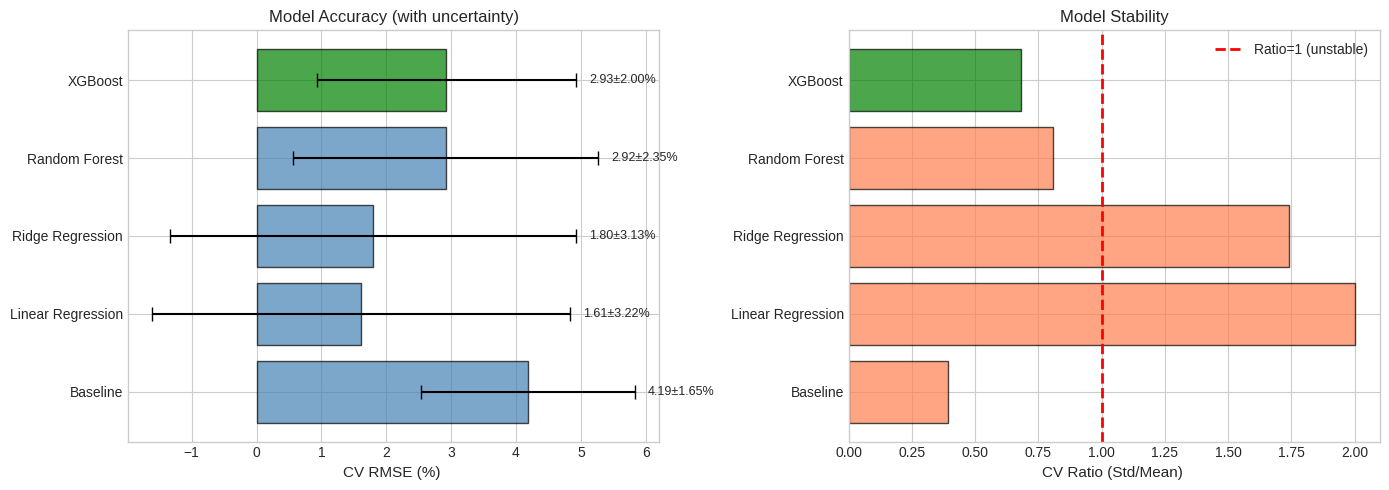

In [99]:
#Model Comparison

comparison_data = []
for name, results in model_results.items():
    cv_ratio = results['cv_rmse_std'] / results['cv_rmse_mean'] if results['cv_rmse_mean'] > 0 else float('inf')
    comparison_data.append({
        'Model': name,
        'CV RMSE (%)': results['cv_rmse_mean'],
        'Std (%)': results['cv_rmse_std'],
        'CV Ratio': cv_ratio
    })

comparison_df = pd.DataFrame(comparison_data)

comparison_df_sorted = comparison_df.sort_values('CV Ratio')
print("Model Comparison (sorted by reliability):")
print(comparison_df_sorted.to_string(index=False))

# Selecting best model (excluding baseline)
non_baseline = comparison_df_sorted[comparison_df_sorted['Model'] != 'Baseline']
best_model_name = non_baseline.iloc[0]['Model']
best_model = model_results[best_model_name]['model']

print(f"\n SELECTED MODEL: {best_model_name} ")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

models = comparison_df['Model'].tolist()
means = comparison_df['CV RMSE (%)'].tolist()
stds = comparison_df['Std (%)'].tolist()
ratios = comparison_df['CV Ratio'].tolist()

colors = ['green' if m == best_model_name else 'steelblue' for m in models]

# Plot 1: RMSE with error bars
axes[0].barh(models, means, xerr=stds, capsize=5, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_xlabel('CV RMSE (%) ', fontsize=11)
axes[0].set_title('Model Accuracy (with uncertainty)', fontsize=12)
for i, (m, s) in enumerate(zip(means, stds)):
    axes[0].text(m + s + 0.2, i, f'{m:.2f}±{s:.2f}%', va='center', fontsize=9)

# Plot 2: CV Ratio
colors2 = ['green' if m == best_model_name else 'coral' for m in models]
axes[1].barh(models, ratios, color=colors2, alpha=0.7, edgecolor='black')
axes[1].set_xlabel('CV Ratio (Std/Mean) ', fontsize=11)
axes[1].set_title('Model Stability', fontsize=12)
axes[1].axvline(x=1, color='red', linestyle='--', linewidth=2, label='Ratio=1 (unstable)')
axes[1].legend()

plt.tight_layout()
plt.show()

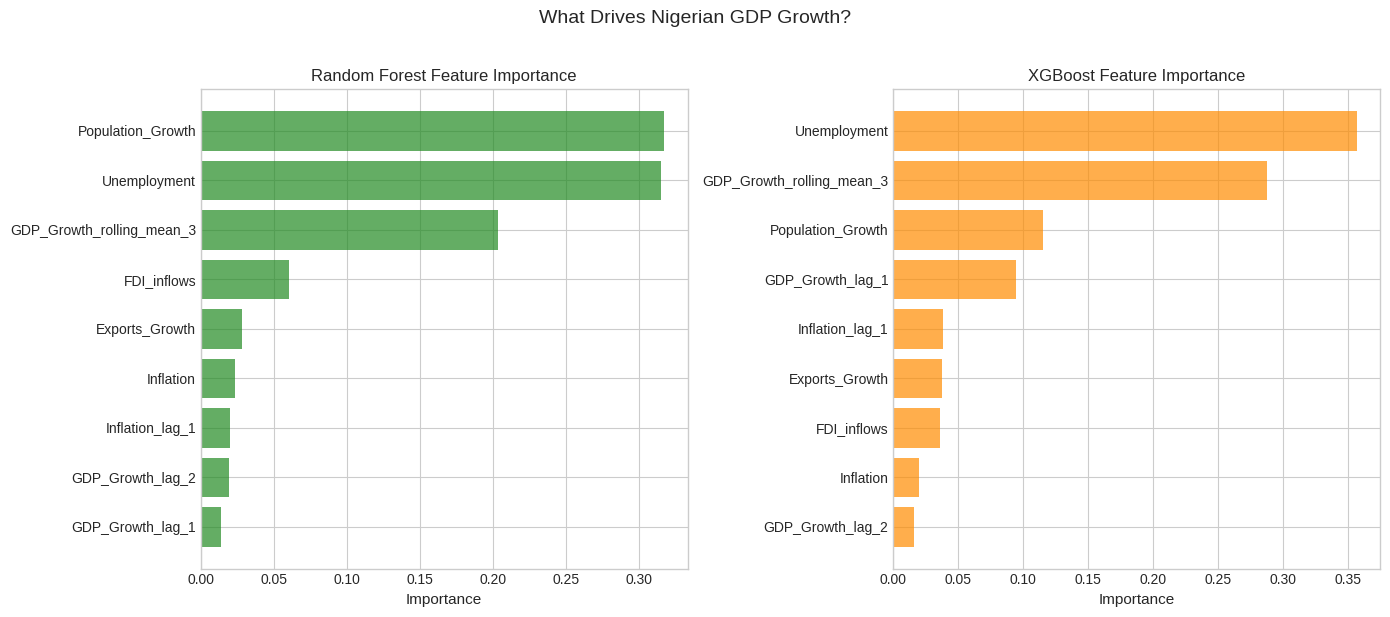


Top Features (Random Forest):
  1. Population_Growth: 31.7%
  2. Unemployment: 31.5%
  3. GDP_Growth_rolling_mean_3: 20.3%
  4. FDI_inflows: 6.0%
  5. Exports_Growth: 2.8%

Top Features (XGBoost):
  1. Unemployment: 35.7%
  2. GDP_Growth_rolling_mean_3: 28.8%
  3. Population_Growth: 11.5%
  4. GDP_Growth_lag_1: 9.4%
  5. Inflation_lag_1: 3.8%


In [101]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Random Forest importance
rf_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_best.feature_importances_
}).sort_values('Importance', ascending=True)

axes[0].barh(rf_importance['Feature'], rf_importance['Importance'], color='forestgreen', alpha=0.7)
axes[0].set_xlabel('Importance', fontsize=11)
axes[0].set_title('Random Forest Feature Importance', fontsize=12)

# XGBoost importance
xgb_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': xgb_best.feature_importances_
}).sort_values('Importance', ascending=True)

axes[1].barh(xgb_importance['Feature'], xgb_importance['Importance'], color='darkorange', alpha=0.7)
axes[1].set_xlabel('Importance', fontsize=11)
axes[1].set_title('XGBoost Feature Importance', fontsize=12)

plt.suptitle('What Drives Nigerian GDP Growth?', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("\nTop Features (Random Forest):")
for i, (_, row) in enumerate(rf_importance.tail(5).iloc[::-1].iterrows()):
    print(f"  {i+1}. {row['Feature']}: {row['Importance']:.1%}")

print("\nTop Features (XGBoost):")
for i, (_, row) in enumerate(xgb_importance.tail(5).iloc[::-1].iterrows()):
    print(f"  {i+1}. {row['Feature']}: {row['Importance']:.1%}")



Holdout Performance:
            Model  Holdout MAE (%)  Holdout RMSE (%)
Linear Regression             0.00              0.00
 Ridge Regression             0.00              0.00
    Random Forest             1.07              1.12
          XGBoost             1.54              1.59

⚠️  Holdout has only 2 samples - interpret with caution
    CV scores (Section 12) are more reliable for model comparison


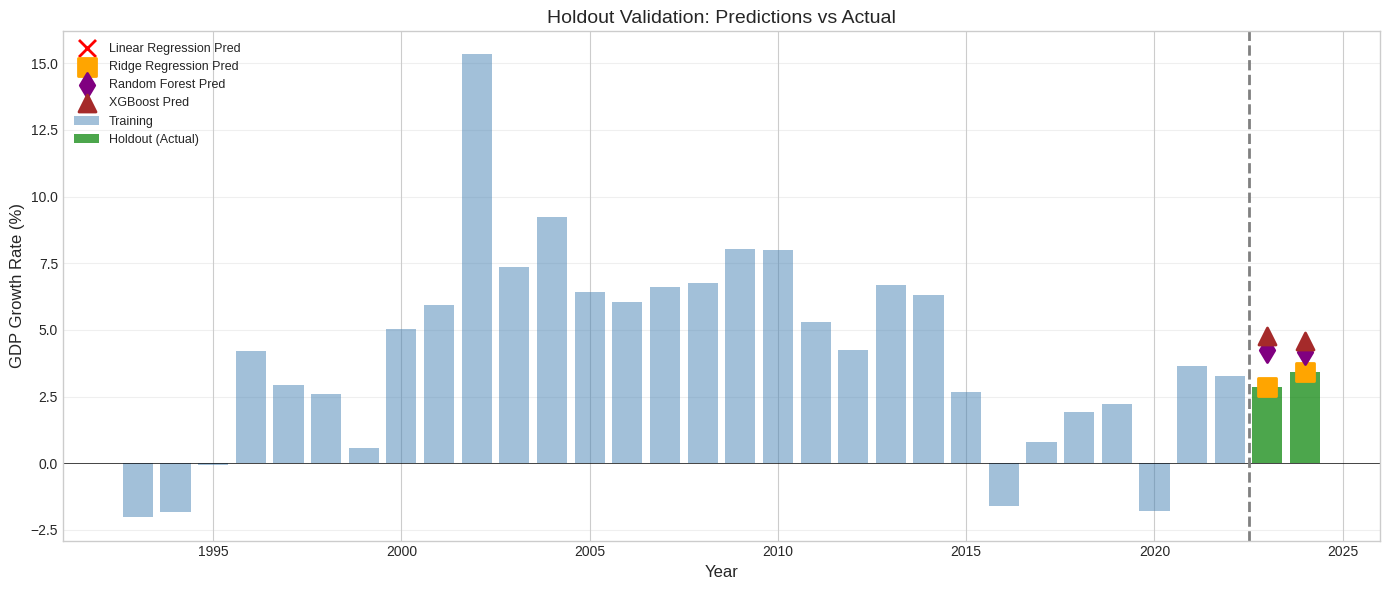

In [103]:
holdout_results = []
for name, results in model_results.items():
    if results['model'] is not None:
        y_pred = results['model'].predict(X_holdout_scaled)
        mae = mean_absolute_error(y_holdout, y_pred)
        rmse = np.sqrt(mean_squared_error(y_holdout, y_pred))

        holdout_results.append({
            'Model': name,
            'Holdout MAE (%)': mae,
            'Holdout RMSE (%)': rmse,
            'Predictions': y_pred,
            'Actual': y_holdout.values
        })

holdout_df_results = pd.DataFrame(holdout_results)
print("\nHoldout Performance:")
print(holdout_df_results[['Model', 'Holdout MAE (%)', 'Holdout RMSE (%)']].round(2).to_string(index=False))

print(f"\n⚠️  Holdout has only {len(y_holdout)} samples - interpret with caution")
print("    CV scores (Section 12) are more reliable for model comparison")

# Visualization
fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(train_df['Year'], y_train, color='steelblue', alpha=0.5, label='Training')
ax.bar(holdout_df['Year'], y_holdout, color='green', alpha=0.7, label='Holdout (Actual)')

markers = ['x', 's', 'd', '^']
colors = ['red', 'orange', 'purple', 'brown']
for i, result in enumerate(holdout_results):
    ax.scatter(holdout_df['Year'], result['Predictions'],
               marker=markers[i % len(markers)], s=150, linewidths=2,
               color=colors[i % len(colors)], label=f"{result['Model']} Pred", zorder=5)

ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.axvline(x=HOLDOUT_START_YEAR - 0.5, color='gray', linestyle='--', linewidth=2)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('GDP Growth Rate (%)', fontsize=12)
ax.set_title('Holdout Validation: Predictions vs Actual', fontsize=14)
ax.legend(loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


SECTION 15: FUTURE PREDICTIONS (2025-2026)
Last known year: 2024
Last GDP Growth: 3.43%

------------------------------------------------------------
FUTURE GDP GROWTH PREDICTIONS
------------------------------------------------------------

OPTIMISTIC SCENARIO
  Economic recovery, improved conditions
  2025 Predicted GDP Growth: 2.44%
  2026 Predicted GDP Growth: 2.44%

BASELINE SCENARIO
  Current trends continue
  2025 Predicted GDP Growth: 2.72%
  2026 Predicted GDP Growth: 2.72%

PESSIMISTIC SCENARIO
  Economic challenges, unfavorable conditions
  2025 Predicted GDP Growth: 2.41%
  2026 Predicted GDP Growth: 2.41%

------------------------------------------------------------
PREDICTION SUMMARY
------------------------------------------------------------
   Scenario     2025     2026
 Optimistic 2.435734 2.435734
   Baseline 2.724731 2.724731
Pessimistic 2.408474 2.408474

2025 GDP Growth Range: 2.41% to 2.72%
2026 GDP Growth Range: 2.41% to 2.72%


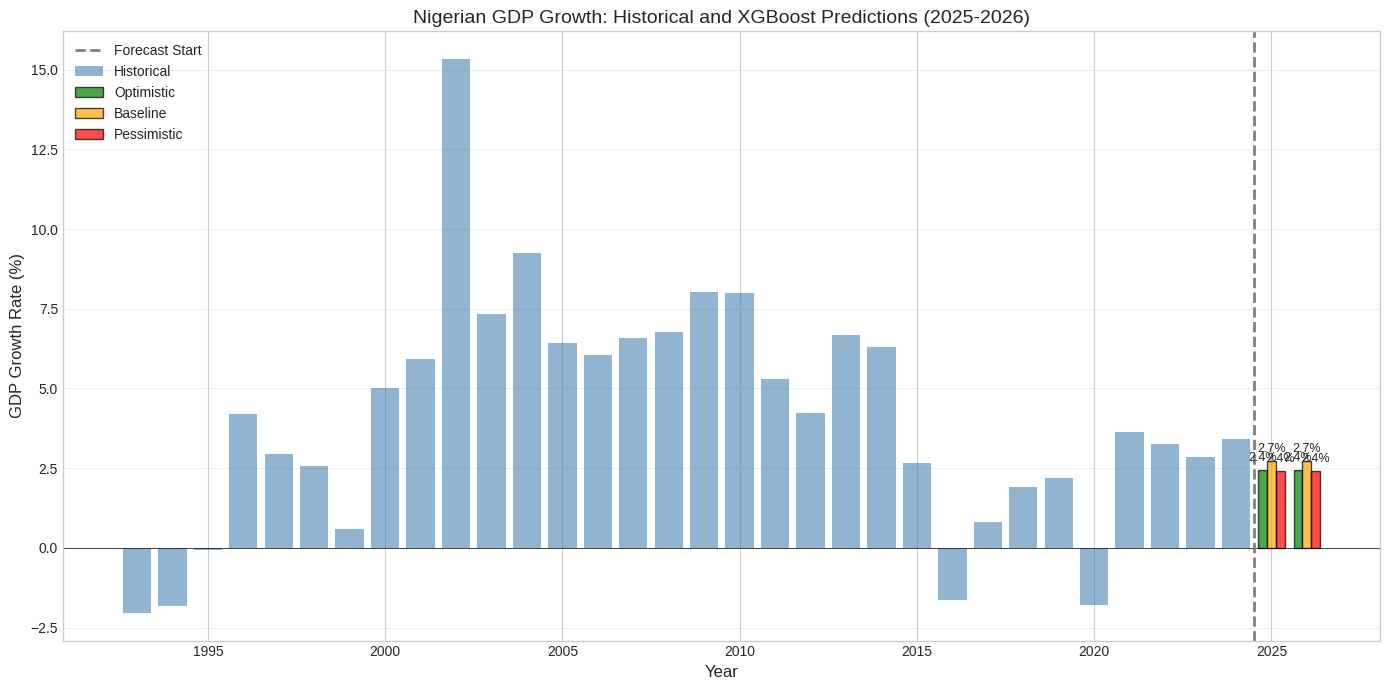


SECTION 16: RESIDUAL ANALYSIS


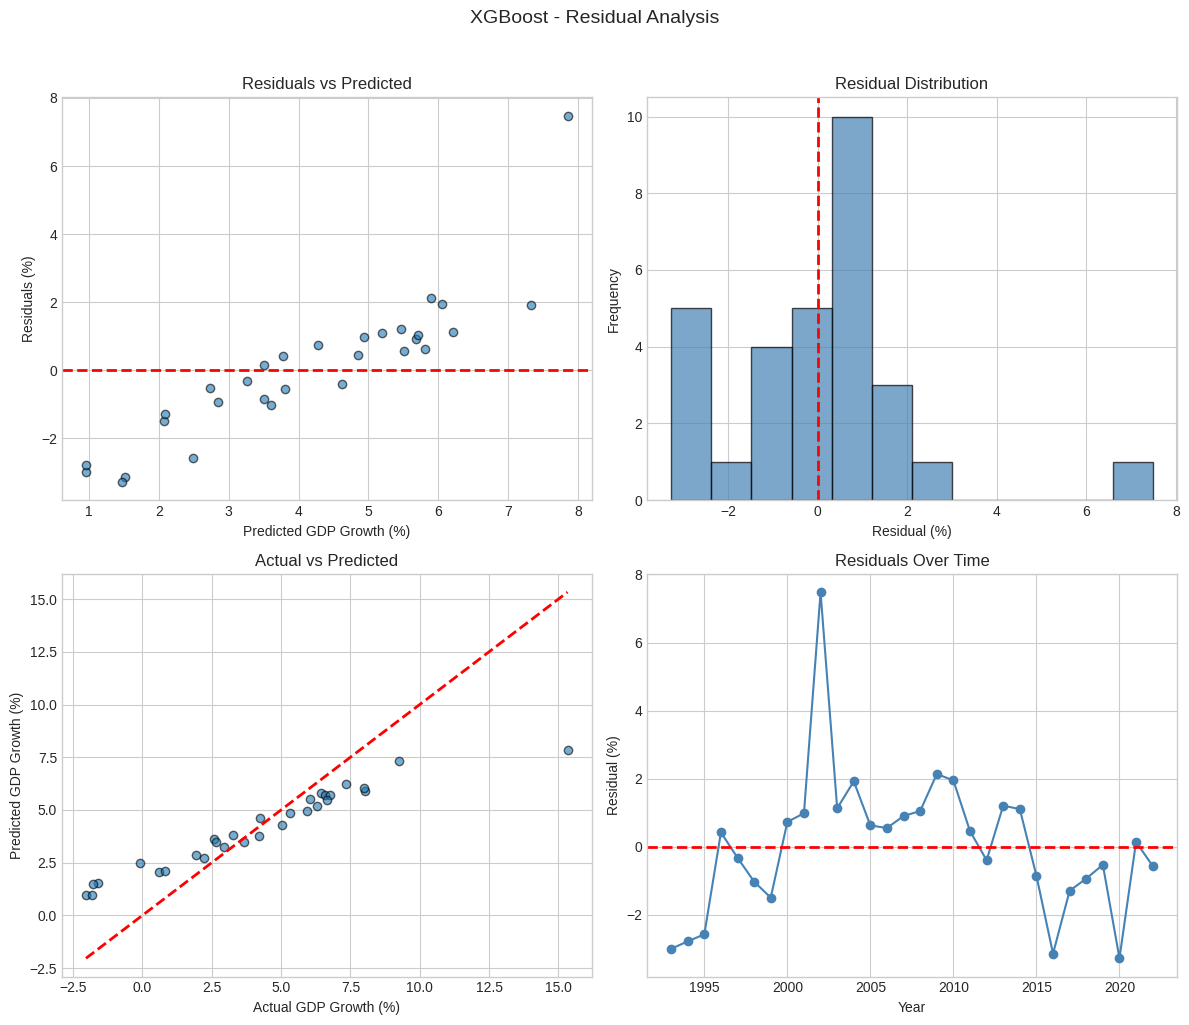

In [112]:
print("\n" + "="*70)
print("SECTION 15: FUTURE PREDICTIONS (2025-2026)")
print("="*70)

# Get recent values for reference
print(f"Last known year: {last_known_year}")
print(f"Last GDP Growth: {last_known_data['GDP_Growth']:.2f}%")

# Define scenarios
# Using actual feature columns that exist in our model
scenarios = {
    'Optimistic': {
        'description': 'Economic recovery, improved conditions',
        2025: {
            'Inflation': 15.0,
            'Population_Growth': 2.4,
            'FDI_inflows': 1.5,
            'Unemployment': 4.0,
            'Exports_Growth': 10.0,  # Strong export growth
            'GDP_Growth_lag_1': last_known_data['GDP_Growth'],
            'GDP_Growth_lag_2': df_featured[df_featured['Year'] == last_known_year - 1]['GDP_Growth'].values[0] if len(df_featured[df_featured['Year'] == last_known_year - 1]) > 0 else 3.0,
            'Inflation_lag_1': last_known_data['Inflation'],
            'GDP_Growth_rolling_mean_3': df_featured['GDP_Growth'].tail(3).mean()
        }
    },
    'Baseline': {
        'description': 'Current trends continue',
        2025: {
            'Inflation': 22.0,
            'Population_Growth': 2.4,
            'FDI_inflows': 0.8,
            'Unemployment': 5.0,
            'Exports_Growth': 3.0,  # Moderate export growth
            'GDP_Growth_lag_1': last_known_data['GDP_Growth'],
            'GDP_Growth_lag_2': df_featured[df_featured['Year'] == last_known_year - 1]['GDP_Growth'].values[0] if len(df_featured[df_featured['Year'] == last_known_year - 1]) > 0 else 3.0,
            'Inflation_lag_1': last_known_data['Inflation'],
            'GDP_Growth_rolling_mean_3': df_featured['GDP_Growth'].tail(3).mean()
        }
    },
    'Pessimistic': {
        'description': 'Economic challenges, unfavorable conditions',
        2025: {
            'Inflation': 30.0,
            'Population_Growth': 2.4,
            'FDI_inflows': 0.3,
            'Unemployment': 6.5,
            'Exports_Growth': -5.0,  # Export decline
            'GDP_Growth_lag_1': last_known_data['GDP_Growth'],
            'GDP_Growth_lag_2': df_featured[df_featured['Year'] == last_known_year - 1]['GDP_Growth'].values[0] if len(df_featured[df_featured['Year'] == last_known_year - 1]) > 0 else 3.0,
            'Inflation_lag_1': last_known_data['Inflation'],
            'GDP_Growth_rolling_mean_3': df_featured['GDP_Growth'].tail(3).mean()
        }
    }
}

# Make predictions
print("\n" + "-"*60)
print("FUTURE GDP GROWTH PREDICTIONS")
print("-"*60)

prediction_results = []

for scenario_name, scenario_data in scenarios.items():
    print(f"\n{scenario_name.upper()} SCENARIO")
    print(f"  {scenario_data['description']}")

    # Predict 2025
    features_2025 = {f: scenario_data[2025].get(f, 0) for f in feature_cols}
    features_2025_df = pd.DataFrame([features_2025])[feature_cols]
    features_2025_scaled = scaler.transform(features_2025_df)
    pred_2025 = best_model.predict(features_2025_scaled)[0]
    print(f"  2025 Predicted GDP Growth: {pred_2025:.2f}%")

    # Prepare 2026 features (using 2025 prediction for lags)
    features_2026 = features_2025.copy()
    features_2026['GDP_Growth_lag_1'] = pred_2025
    features_2026['GDP_Growth_lag_2'] = scenario_data[2025]['GDP_Growth_lag_1']
    features_2026['Inflation_lag_1'] = scenario_data[2025]['Inflation']
    # Keep same Exports_Growth assumption for 2026
    features_2026['Exports_Growth'] = scenario_data[2025]['Exports_Growth']
    # Update rolling mean
    recent_growth = [scenario_data[2025]['GDP_Growth_lag_2'], scenario_data[2025]['GDP_Growth_lag_1'], pred_2025]
    features_2026['GDP_Growth_rolling_mean_3'] = np.mean(recent_growth)

    features_2026_df = pd.DataFrame([features_2026])[feature_cols]
    features_2026_scaled = scaler.transform(features_2026_df)
    pred_2026 = best_model.predict(features_2026_scaled)[0]
    print(f"  2026 Predicted GDP Growth: {pred_2026:.2f}%")

    prediction_results.append({
        'Scenario': scenario_name,
        '2025': pred_2025,
        '2026': pred_2026
    })

# Summary
pred_df = pd.DataFrame(prediction_results)
print("\n" + "-"*60)
print("PREDICTION SUMMARY")
print("-"*60)
print(pred_df.to_string(index=False))
print(f"\n2025 GDP Growth Range: {pred_df['2025'].min():.2f}% to {pred_df['2025'].max():.2f}%")
print(f"2026 GDP Growth Range: {pred_df['2026'].min():.2f}% to {pred_df['2026'].max():.2f}%")

# Visualization
fig, ax = plt.subplots(figsize=(14, 7))

# Historical data
historical_years = df_featured['Year'].values
historical_growth = df_featured['GDP_Growth'].values
ax.bar(historical_years, historical_growth, color='steelblue', alpha=0.6, label='Historical')

# Future predictions
future_years = [2025, 2026]
width = 0.25
scenario_colors = {'Optimistic': 'green', 'Baseline': 'orange', 'Pessimistic': 'red'}

for i, result in enumerate(prediction_results):
    scenario = result['Scenario']
    values = [result['2025'], result['2026']]
    offset = (i - 1) * width
    bars = ax.bar([y + offset for y in future_years], values, width=width,
                  color=scenario_colors[scenario], alpha=0.7, label=scenario, edgecolor='black')
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
                f'{val:.1f}%', ha='center', va='bottom', fontsize=9)

ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.axvline(x=last_known_year + 0.5, color='gray', linestyle='--', linewidth=2, label='Forecast Start')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('GDP Growth Rate (%)', fontsize=12)
ax.set_title(f'Nigerian GDP Growth: Historical and {best_model_name} Predictions (2025-2026)', fontsize=14)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


# ==============================================================================
# SECTION 16: RESIDUAL ANALYSIS
# ==============================================================================

print("\n" + "="*70)
print("SECTION 16: RESIDUAL ANALYSIS")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

y_pred_train = best_model.predict(X_train_scaled)
residuals = y_train.values - y_pred_train

# Residuals vs Predicted
axes[0, 0].scatter(y_pred_train, residuals, alpha=0.6, edgecolors='black')
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Predicted GDP Growth (%)')
axes[0, 0].set_ylabel('Residuals (%)')
axes[0, 0].set_title('Residuals vs Predicted')

# Residual histogram
axes[0, 1].hist(residuals, bins=12, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Residual (%)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Residual Distribution')

# Actual vs Predicted
axes[1, 0].scatter(y_train, y_pred_train, alpha=0.6, edgecolors='black')
min_val, max_val = min(y_train.min(), y_pred_train.min()), max(y_train.max(), y_pred_train.max())
axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[1, 0].set_xlabel('Actual GDP Growth (%)')
axes[1, 0].set_ylabel('Predicted GDP Growth (%)')
axes[1, 0].set_title('Actual vs Predicted')

# Residuals over time
axes[1, 1].plot(train_df['Year'], residuals, 'o-', color='steelblue')
axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Residual (%)')
axes[1, 1].set_title('Residuals Over Time')

plt.suptitle(f'{best_model_name} - Residual Analysis', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

